In [1]:
%matplotlib inline
import sys, os, time
sys.path.append("..")
from pathlib import Path
import json

import numpy as np
import rasterio

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

In [2]:
from viz_utils import VizUtils

In [17]:
with open("../constants/class_lists/wcs_fine_coarse_label_maps.json","r") as f:
    label_maps = json.loads(f.read())

In [3]:
with open("../constants/splits/full_sr_median_2013_2014_splits.json", "r") as f:
    splits = json.loads(f.read())

In [4]:
IMAGES_DIR = Path("/home/caleb/data1/wcs_data/tiles/")
LABELS_DIR = Path("/home/caleb/data1/wcs_data/tiles_masks_coarse/")


def get_image_label_fn_pairs(fns):
    fn_pairs = []
    for fn in fns:
        parts = fn[:-4].split("_")
        lon, lat = parts[-2], parts[-1]

        image_fn = IMAGES_DIR / fn
        label_fn = LABELS_DIR / ("mask_%s_%s.tif" % (lon, lat))

        if label_fn.exists():        
            fn_pairs.append((image_fn, label_fn))
        else:
            print("Skipping %s because there isn't a matching label filename" % (fn))
    return fn_pairs

train_fns = get_image_label_fn_pairs(splits["train"])
val_fns = get_image_label_fn_pairs(splits["val"])

print("Number of training tiles: %d" % (len(train_fns)))
print("Number of validation tiles: %d" % (len(val_fns)))

Number of training tiles: 133
Number of validation tiles: 15


In [11]:
%%time

class_counts = []
for i, (image_fn, label_fn) in enumerate(train_fns):
    if i % 10 == 0:
        print(i, len(train_fns))
    with rasterio.open(image_fn, "r") as f:
        data = np.rollaxis(f.read(), 0, 3)
    with rasterio.open(label_fn, "r") as f:
        labels = f.read().squeeze()
        
    vals, counts = np.unique(labels, return_counts=True)    
    class_counts.append((vals, counts))

0 133
10 133
20 133
30 133
40 133
50 133
60 133
70 133
80 133
90 133
100 133
110 133
120 133
130 133
CPU times: user 3min 3s, sys: 4.68 s, total: 3min 8s
Wall time: 3min 8s


In [12]:
data.shape, labels.shape

((2000, 2000, 10), (2000, 2000))

In [58]:
%%time
n_samples_per_tile = 5000

x_train_tiles = np.zeros((len(train_fns), 2000, 2000, 10), dtype=np.float64)
y_train_tiles = np.zeros((len(train_fns), 2000, 2000), dtype=np.uint8)

x_train = np.zeros((n_samples_per_tile * len(train_fns), 10), dtype=np.float64)
y_train = np.zeros((n_samples_per_tile * len(train_fns)), dtype=np.int32)

for i, (image_fn, label_fn) in enumerate(train_fns):
    if i % 10 == 0:
        print(i, len(train_fns))
    with rasterio.open(image_fn, "r") as f:
        data = np.rollaxis(f.read(), 0, 3)
    with rasterio.open(label_fn, "r") as f:
        labels = f.read().squeeze()
        
    x_train_tiles[i] = data
    y_train_tiles[i] = labels
        
    data = data.reshape(-1, 10)
    labels = labels.reshape(-1,)
    
    idxs = np.random.choice(data.shape[0], replace=False, size=n_samples_per_tile)
    
    x_train[(i)*n_samples_per_tile:(i+1)*n_samples_per_tile] = data[idxs]
    y_train[(i)*n_samples_per_tile:(i+1)*n_samples_per_tile] = labels[idxs]

0 133
10 133
20 133
30 133
40 133
50 133
60 133
70 133
80 133
90 133
100 133
110 133
120 133
130 133
CPU times: user 3min 22s, sys: 34.2 s, total: 3min 56s
Wall time: 3min 56s


In [73]:
x_train_tiles = x_train_tiles.reshape(-1,10)
y_train_tiles = y_train_tiles.reshape(-1)

In [74]:
print("Class counts all:")
vals, counts = np.unique(y_train_tiles, return_counts=True)
for val, count in zip(vals, counts):
    print("%s (%d)\t%0.2f%%\t%d" % (label_maps["wcs_num_to_name"][str(val)], val, count / counts.sum() * 100, count))

Class counts all:
Empty of data (0)	20.65%	109880338
Urban and infrastructure (1)	0.06%	300046
Agriculture (2)	3.97%	21114120
Arboreal and forestry crops (3)	0.52%	2787604
Pasture (4)	5.95%	31638817
Vegetation (5)	1.99%	10574669
Forest (6)	36.33%	193271855
Savanna (7)	1.71%	9119246
Sand, rocks and bare land (8)	0.14%	731057
Unavailable (9)	0.25%	1305558
Swamp (10)	0.25%	1312385
Water (11)	1.05%	5598361
Seasonal savanna (12)	16.15%	85926785
Seasonally flooded savanna (13)	10.98%	58439159


In [85]:
n_samples_per_class = 40000

x_train = []
y_train = []

for class_idx in range(1,14):
    print("Sampling for class %d" % (class_idx))
    idxs = np.where(y_train_tiles == class_idx)[0]
    idxs = np.random.choice(idxs, size=n_samples_per_class, replace=True)
    x_train.append(x_train_tiles[idxs])
    y_train.append(y_train_tiles[idxs])
    
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

Sampling for class 1
Sampling for class 2
Sampling for class 3
Sampling for class 4
Sampling for class 5
Sampling for class 6
Sampling for class 7
Sampling for class 8
Sampling for class 9
Sampling for class 10
Sampling for class 11
Sampling for class 12
Sampling for class 13


In [92]:
n_samples_per_class = 40000

idxs = np.random.choice(x_train_tiles.shape[0], size=n_samples_per_class * 14, replace=True)
x_train = x_train_tiles[idxs].copy()
y_train = y_train_tiles[idxs].copy()

In [93]:
nan_mask = np.any(np.isnan(x_train), axis=1)
x_train[nan_mask] = 0
print(np.unique(y_train[nan_mask], return_counts=True))
y_train[nan_mask] = 0

(array([ 0,  2,  4,  5,  6,  7,  8, 11, 12], dtype=uint8), array([3796,   14,   18,  145, 1283,  115,    1,    5,    1]))


In [100]:
nodata_mask = y_train == 0
x_train[nodata_mask] = 0

In [94]:
print("Class counts training:")
vals, counts = np.unique(y_train, return_counts=True)
for val, count in zip(vals, counts):
    print("%s (%d)\t%0.2f%%\t%d" % (label_maps["wcs_num_to_name"][str(val)], val, count / counts.sum() * 100, count))

Class counts training:
Empty of data (0)	20.93%	117194
Urban and infrastructure (1)	0.06%	353
Agriculture (2)	3.96%	22200
Arboreal and forestry crops (3)	0.53%	2955
Pasture (4)	5.97%	33406
Vegetation (5)	1.96%	10977
Forest (6)	36.08%	202033
Savanna (7)	1.69%	9470
Sand, rocks and bare land (8)	0.13%	752
Unavailable (9)	0.24%	1367
Swamp (10)	0.25%	1389
Water (11)	1.04%	5850
Seasonal savanna (12)	16.16%	90524
Seasonally flooded savanna (13)	10.99%	61530


In [140]:
%%time
model = RandomForestClassifier(n_jobs=24, n_estimators=50)
model.fit(x_train, y_train)

CPU times: user 1min 46s, sys: 1.03 s, total: 1min 47s
Wall time: 6.24 s


RandomForestClassifier(n_estimators=50, n_jobs=24)

In [141]:
%%time
y_true_tiles = np.zeros((len(val_fns), 2000, 2000), dtype=np.uint8)
y_pred_tiles = np.zeros((len(val_fns), 2000, 2000), dtype=np.uint8)

tic = float(time.time())
for i, (image_fn, label_fn) in enumerate(val_fns):
    if i % 5 == 0:
        print(i, len(val_fns), time.time()-tic)
        tic = float(time.time())
        
    with rasterio.open(image_fn, "r") as f:
        data = np.rollaxis(f.read(), 0, 3)
    with rasterio.open(label_fn, "r") as f:
        labels = f.read().squeeze()
            
    data = data.reshape(-1, 10)
    nan_mask = np.any(np.isnan(data), axis=1)

    data[nan_mask] = 0
    y_true = labels.reshape(-1,)
    
    y_pred = model.predict(data).astype(np.uint8)
    
    y_pred[nan_mask] = 0
    
    y_pred_tiles[i] = y_pred.reshape(2000,2000)
    y_true_tiles[i] = y_true.reshape(2000,2000)

0 15 1.239776611328125e-05
5 15 64.12146019935608
10 15 61.065794467926025
CPU times: user 15min 39s, sys: 12min 5s, total: 27min 45s
Wall time: 2min 56s


In [113]:
viz = VizUtils("wcs_fine_coarse_label_maps.json")

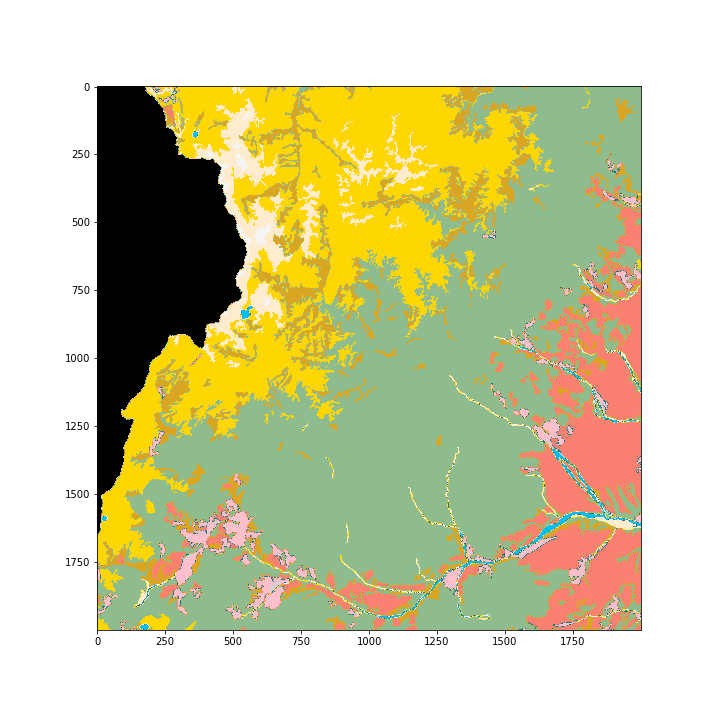

In [142]:
viz.show_label_raster(y_true_tiles[0])[0]

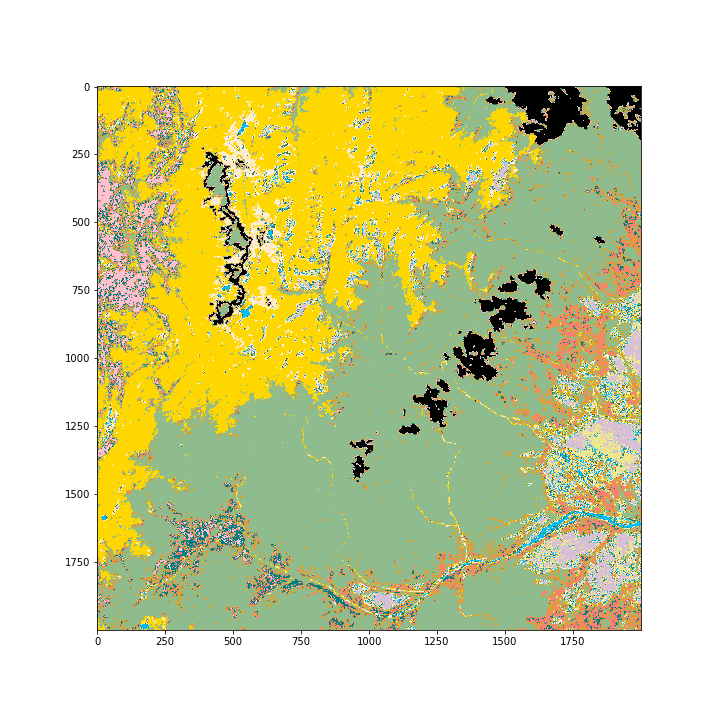

In [143]:
viz.show_label_raster(y_pred_tiles[0])[0]

In [145]:
y_preds = []
for i in range(y_pred_tiles.shape[0]):
    y_preds.append(scipy.ndimage.median_filter(y_pred_tiles[i],size=5))
y_preds = np.array(y_preds).reshape(-1,)

In [144]:
y_true = y_true_tiles.reshape(-1,)

In [125]:
def get_cnf(raster1, raster2, classes):
    
    cnf = np.zeros((len(classes), len(classes)), dtype=int)
    for i, class_a in enumerate(classes):
        mask1 = raster1 == class_a
        for j, class_b in enumerate(classes):
            mask2 = raster2 == class_b
            overlap = np.sum(mask1 & mask2)
            cnf[i,j] = overlap
            
    return cnf

In [146]:
num_classes = 14
cm = get_cnf(y_true, y_preds, list(range(num_classes)))

In [147]:
classes_present_in_gt = np.unique(y_true)

In [148]:
classes_present_in_gt

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=uint8)

In [149]:
np.unique(y_preds)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=uint8)

In [150]:
total_obs = cm.sum()

per_class_accuracy = {}
per_class_recall = {}
per_class_precision = {}

for cls in range(num_classes):
    if cls not in classes_present_in_gt:
        continue
        
    true_pos = cm[cls, cls]
    
    true_neg = total_obs - cm[cls, :].sum() - cm[:, cls].sum() + true_pos
    
    false_pos = cm[:, cls].sum() - true_pos
    
    false_neg = cm[cls, :].sum() - true_pos
    
    per_class_accuracy[cls] = (true_pos + true_neg) / total_obs
    
    per_class_precision[cls] = true_pos / (true_pos + false_pos)
    
    per_class_recall[cls] = true_pos / (true_pos + false_neg)

In [152]:
for cls, acc in per_class_accuracy.items():
    prec = per_class_precision[cls]
    recall = per_class_recall[cls]
    print(f'{cls} {label_maps["wcs_num_to_name"][str(cls)]},{acc},{prec},{recall}')

0 Empty of data,0.6734255666666666,0.22408919132453956,0.11671147240411378
1 Urban and infrastructure,0.9985908166666667,0.017251131221719458,0.0024626895799970392
2 Agriculture,0.8962647333333333,0.2965878342357711,0.21387258012834498
3 Arboreal and forestry crops,0.9939105833333334,0.25666767007826613,0.051205443337106755
4 Pasture,0.8872791166666667,0.46718450752349333,0.4202877331944504
5 Vegetation,0.9584894166666666,0.14678786632716,0.016057741258641445
6 Forest,0.8224525666666667,0.6018360466107346,0.8350316936569855
7 Savanna,0.95212325,0.5056429237561962,0.5392844208786413
8 Sand, rocks and bare land,0.99609655,0.4939627977809203,0.13617358522897657
9 Unavailable,0.99817415,0.0,0.0
10 Swamp,0.9970988,0.1710680751173709,0.006875486473099512
11 Water,0.9826308,0.41823605798585994,0.5025137339770268
12 Seasonal savanna,0.8540314,0.36613875040062893,0.8290167707821933
13 Seasonally flooded savanna,0.8979317833333333,0.5135307183043014,0.4390524059121347
